In [1]:
import copy
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
seed=0
import random
random.seed(seed)
import torch
import pickle
torch.manual_seed(seed)
X_train = pd.read_csv('datamart/X_train_clipped_scaled.csv').values
y_train = pd.read_csv('datamart/y_lactose_train.csv').values
X_test = pd.read_csv('datamart/X_test_clipped_scaled.csv').values
y_test = pd.read_csv('datamart/y_lactose_test.csv').values

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


In [2]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
      layer.reset_parameters()

In [3]:
def nn_cross_validation(X_train, y_train, model, loss, optimizer_name, lr=None, weight_decay=0.0, n_epochs=1000, batch_size=10,  kf=None, log=False, id=None ):

    if log:
        name = 'logs/NN/' + f'{id}' + '_random_search.csv'
        with open(name, 'w', newline='\n') as csvfile:
            w = csv.writer(csvfile, delimiter=';')
            w.writerow(['id']+['fold']+['best_score']+['best_generations'])
    

    results = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_train_cross, X_val = X_train[train_index], X_train[val_index]
        y_train_cross, y_val = y_train[train_index], y_train[val_index]
        
        model.apply(reset_weights) 
        # Initialize the optimizer, we have to do this each fold otherwise the optimizer will continue from where it left off
        #this is also why wi initialize it within the cross validaion 
        optimizer = get_optimizer(model.parameters(),optimizer_name, lr=lr, weight_decay=weight_decay)
        
        batch_start = torch.arange(0, len(X_train_cross), batch_size)
        
        for epoch in range(n_epochs):
            model.train()
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # Take a batch
                    X_batch = X_train_cross[start:start+batch_size]
                    y_batch = y_train_cross[start:start+batch_size]
                    # Forward pass
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred, y_batch)
                    loss.backward()
                    # Backward pass
                    optimizer.step()
                    optimizer.zero_grad()
                    
                    # Update weights
                    
                    # Print progress
                    bar.set_postfix(mse=float(loss))
            
            # Evaluate accuracy at end of each epoch
            model.eval()
            y_pred = model(X_val)
            mse = loss_fn(y_pred, y_val)
            mse = float(mse)    
            if log:
                name = 'logs/NN/' + f'{id}'+ '_random_search.csv'
                with open(name, 'a', newline='\n') as csvfile:
                    w = csv.writer(csvfile, delimiter=';')
                    w.writerow([id]+[fold]+[mse]+[epoch])
                    
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
                
        results.append(mse)
        
    avg_mse = np.mean(results)
    print(avg_mse)
    return avg_mse
        

    

In [4]:
def create_model():
    return nn.Sequential(
        nn.Linear(12, 1),
        nn.Linear(1, 1),
    )

def eval_model(model, X_test, y_test):
    pred = model.forward(X_test)[:, 0]
    return mean_squared_error(y_test, pred)

def create_random_model():
    n_neurons_1 = random.randint(1,10)
    n_neurons_2 = random.randint(1,10)
    r1 = random.uniform(0,1)
    r2 = random.uniform(0,1)
    model = nn.Sequential(nn.Linear( 12, n_neurons_1))
    
    if r1 < 0.25:
        model.add_module('relu1', nn.ReLU())
        
    elif 0.25 < r1< 0.5:
        model.add_module('sigmoid1', nn.Sigmoid())
    
    if 0.5 < r1 < 0.75:
        model.add_module('linear', nn.Linear(n_neurons_1, n_neurons_2))
        
        if r2 < 0.25:
            model.add_module('relu2', nn.ReLU())
        elif 0.25 < r2 < 0.5:
            model.add_module('sigmoid2', nn.Sigmoid())
        model.add_module('output', nn.Linear(n_neurons_2, 1))
        return model
    
    
    model.add_module('output', nn.Linear(n_neurons_1,1))
    # if r2 > 0.25:
    #     model.add_module('relu2', nn.ReLU())
    # elif 0.25 < r2 < 0.5:
    #     model.add_module('sigmoid2', nn.Sigmoid())
    return model

def get_optimizer(model_params, optimizer_name, lr, weight_decay=0.0):

    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adadelta':
        return optim.Adadelta(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'ASGD':
        return optim.ASGD(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model_params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError('Invalid optimizer name')

def random_optimizer():
    r = random.uniform(0,1)
    if r < 0.2:
        return 'Adam'
    elif 0.2 < r < 0.4:
        return 'SGD'
    elif 0.4 < r < 0.6:
        return 'Adadelta'
    elif 0.6 < r < 0.8:
        return 'ASGD'
    return 'RMSprop'


In [5]:
def nn_train(X_train, y_train, model, loss_fn, optimizer_name, lr=None, weight_decay=0.0, n_epochs=1000, batch_size=10, log=False, id=None):
    
    if log:
        name = 'logs/NN/' + f'{id}' + '_training_log.csv'
        with open(name, 'w', newline='\n') as csvfile:
            w = csv.writer(csvfile, delimiter=';')
            w.writerow(['id', 'epoch', 'train_loss'])
    
    # Reset model weights
    model.apply(reset_weights)
    
    
    optimizer = get_optimizer(model.parameters(), optimizer_name, lr=lr, weight_decay=weight_decay)
    
    batch_start = torch.arange(0, len(X_train), batch_size)
    
    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # Take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                
                # Forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                
                # Backward pass
                optimizer.step()
                optimizer.zero_grad()
                
                # Store the batch loss
                train_losses.append(loss.item())
                

        
        # Evaluate on validation set
        model.eval()
        
        avg_train_loss = np.mean(train_losses)
        
        if log:
            with open(name, 'a', newline='\n') as csvfile:
                w = csv.writer(csvfile, delimiter=';')
                w.writerow([id, epoch, avg_train_loss])
        
        # Save best model
        
    with open('models/NN/'+str(id)+'_NN.pkl', 'wb') as f:
            pickle.dump(model, f)
    
    
    return 

In [6]:
model = create_model()
loss_fn = nn.MSELoss()
lr = 0.001
n_epochs = 400   # number of epochs to run
batch_size = 10   # size of each batch
optimizer_name = 'Adam'
# Early stopping parameters
patience = 50  # how many epochs to wait after last improvement
weight_decay = 0.01  # L2 regularization
# K-Fold Cross Validation
kf = RepeatedKFold(n_splits=10, random_state=seed, n_repeats=2)
fold_results = []
nn_cross_validation(X_train=X_train, y_train=y_train, model=model, loss=loss_fn, optimizer_name=optimizer_name, lr=lr, weight_decay=weight_decay, n_epochs=n_epochs, batch_size=batch_size, kf=kf, log=False)

0.0036237230873666705


0.0036237230873666705

In [7]:
kf = RepeatedKFold(n_splits=10, random_state=seed, n_repeats=2)
batch_sizes = [5,10,15,20,25]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
n_epoches = [25, 50, 75, 100, 250, 500, 1000]
weight_decays = [0.0, 0.1, 0.01, 0.001, 0.0001] 
loss_fn = nn.MSELoss()

best_score = np.inf

name = 'logs/NN/' + 'random_search' + '.csv'
with open(name, 'w', newline='\n') as csvfile:
    w = csv.writer(csvfile, delimiter=';')
    w.writerow(['id']+['model']+['optimizer']+['learning_rate']+['l2']+['batch_size']+['n_epochs']+['cv_score'])


for i in range(1000):

    loss_fn = nn.MSELoss()
    batch_size = random.choice(batch_sizes)
    model = create_random_model()
    lr = random.choice(learning_rates)
    optimizer_name = random_optimizer()
    n_epochs = random.choice(n_epoches)
    weight_decay = random.choice(weight_decays)
    score = nn_cross_validation(X_train=X_train, y_train=y_train, model=model, loss=loss_fn, optimizer_name = optimizer_name,lr=lr,  n_epochs=n_epochs, batch_size=batch_size,kf=kf, log=True, id=i)
    
    name = 'logs/NN/' + 'random_search' + '.csv'
    with open(name, 'a', newline='\n') as csvfile:
        w = csv.writer(csvfile, delimiter=';')
        w.writerow([i]+[f'{model}']+[f'{optimizer_name}']+[lr]+[weight_decay]+[batch_size]+[n_epochs]+[score])
    
    if score < best_score:
        best_score = score
        print('Iteration '+ str(i))
        print(f'New best validation score: {best_score}')
        
        nn_train(X_train = X_train, y_train= y_train, model=model, loss_fn = loss_fn, optimizer_name = optimizer_name, lr=lr, weight_decay=weight_decay, n_epochs=n_epochs, batch_size=batch_size, log=True, id=i)
        model = pickle.load(open('models/NN/' + str(i) + '_NN.pkl', 'rb'))
        y_test_pred = model(X_test)
        test_score = loss_fn(y_test_pred, y_test)
        test_score = float(test_score)
        print(f'New best test score: {test_score}')
        
        
    

0.02926812502555549
Iteration 0
New best validation score: 0.02926812502555549
New best test score: 0.045174211263656616
0.0036066928587388247
Iteration 1
New best validation score: 0.0036066928587388247
New best test score: 0.003363759024068713
0.0037389357457868755
0.24434138759970664
0.223229239275679
0.0037171069358009844
0.008428127027582378
0.00923850117251277
0.003971402707975358
23.738884353637694
0.007990941486787051
3.2851772860391066
0.008130776463076472
0.020705861295573412
0.006316631601657718
21.484795570373535
23.01572608947754
0.00446481762919575


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('logs/NN/random_search.csv', delimiter=';')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)


    id                                              model optimizer  \
0    0  Sequential(\n  (0): Linear(in_features=12, out...   RMSprop   
1    1  Sequential(\n  (0): Linear(in_features=12, out...       SGD   
2    2  Sequential(\n  (0): Linear(in_features=12, out...       SGD   
3    3  Sequential(\n  (0): Linear(in_features=12, out...   RMSprop   
4    4  Sequential(\n  (0): Linear(in_features=12, out...      Adam   
5    5  Sequential(\n  (0): Linear(in_features=12, out...      ASGD   
6    6  Sequential(\n  (0): Linear(in_features=12, out...      Adam   
7    7  Sequential(\n  (0): Linear(in_features=12, out...   RMSprop   
8    8  Sequential(\n  (0): Linear(in_features=12, out...       SGD   
9    9  Sequential(\n  (0): Linear(in_features=12, out...  Adadelta   
10  10  Sequential(\n  (0): Linear(in_features=12, out...   RMSprop   
11  11  Sequential(\n  (0): Linear(in_features=12, out...  Adadelta   
12  12  Sequential(\n  (0): Linear(in_features=12, out...   RMSprop   
13  13

<Axes: >

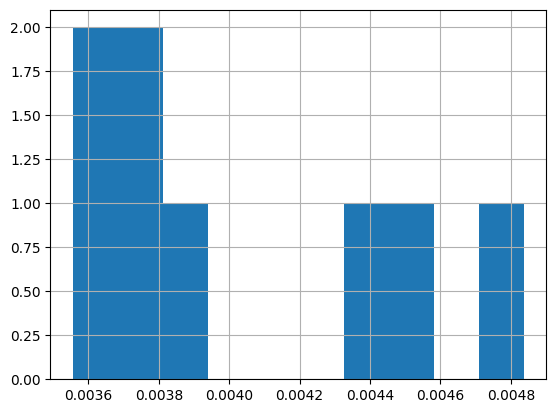

In [ ]:
df.loc[df['cv_score']<0.005, 'cv_score'].hist()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.loc[df['cv_score'] == df['cv_score'].min()])

    id                                              model optimizer  \
18  18  Sequential(\n  (0): Linear(in_features=12, out...       SGD   

    learning_rate     l2  batch_size  n_epochs  cv_score  
18           0.01  0.001           5       500  0.003556  


In [ ]:
;"Sequential(
  (0): Linear(in_features=12, out_features=10, bias=True)
  (linear): Linear(in_features=10, out_features=2, bias=True)
  (sigmoid2): Sigmoid()
  (output): Linear(in_features=2, out_features=1, bias=True)
)";SGD;0.01;0.0001;5;500;0.0034930747002363204

In [ ]:
model = nn.Sequential(nn.Linear( 12, 10), nn.Linear(10, 2), nn.Sigmoid(), nn.Linear(2, 1))
loss_fn = nn.MSELoss()
optimizer_name = 'SGD'
lr = 0.01
weight_decay = 0.0001
n_epochs = 500
batch_size = 5

In [ ]:
nn_train(X_train = X_train, y_train= y_train, model=model, loss_fn = loss_fn, optimizer_name = optimizer_name, lr=lr, weight_decay=weight_decay, n_epochs=n_epochs, batch_size=batch_size, log=False, id=None)

Reset trainable parameters of layer = Linear(in_features=12, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)


Epoch 499: 100%|██████████| 46/46 [00:00<00:00, 373.56batch/s, mse=0.000712]


In [ ]:
model = pickle.load(open('models/NN/59_NN.pkl', 'rb'))
y_test_pred = model(X_test)
test_loss = loss_fn(y_test_pred, y_test)
test_loss = float(test_loss)
test_loss

0.0033063103910535574